# SnapLogic Snap Recommendation

This notebook details how to tackle the recommendation problem using deep learning models. We provide two example models: one where all variables are treated as cross-sectional variables; the other where previous snaps are treated as sequential variables can be studied at the [original repository](https://github.com/Datatouille/snaplogic_snap_recommendation/). See how to [install Pytorch](https://pytorch.org/) on your own environment.

In [1]:
#reload scripts when we edit them
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
np.set_printoptions(threshold=50, edgeitems=20)

#torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [2]:
device

device(type='cpu')

## Load Data

In [3]:
train_df = pd.read_csv("data/snap/train_df.csv")
valid_df = pd.read_csv("data/snap/valid_df.csv")
all_df = pd.concat([train_df,valid_df],0).reset_index(drop=True)
train_df.shape, valid_df.shape

((103541, 8), (14792, 8))

In [4]:
train_df.head()

,org,prev_snap_1,prev_snap_2,prev_snap_3,prev_snap_4,project,target_snap,user
0,3,471,158,0,0,500,286,118
1,1,238,468,0,0,396,63,7
2,3,344,344,344,344,500,349,168
3,3,171,0,0,0,217,211,71
4,3,0,0,0,0,565,51,71


In [5]:
train_df.describe()

,org,prev_snap_1,prev_snap_2,prev_snap_3,prev_snap_4,project,target_snap,user
count,103541.000000,103541.000000,103541.000000,103541.000000,103541.000000,103541.000000,103541.000000,103541.000000
mean,2.674303,185.961629,133.142716,88.953873,54.087231,443.124125,266.926358,128.956510
std,0.737418,152.789966,156.076242,143.168823,120.032965,126.777504,129.226959,52.766921
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,3.000000,30.000000,0.000000,0.000000,0.000000,500.000000,158.000000,71.000000
50%,3.000000,158.000000,66.000000,0.000000,0.000000,500.000000,287.000000,118.000000
75%,3.000000,313.000000,211.000000,158.000000,0.000000,500.000000,349.000000,168.000000
max,4.000000,500.000000,500.000000,500.000000,499.000000,580.000000,500.000000,230.000000


In [6]:
valid_df.target_snap.value_counts().head()

349    3236
158    3078
313     811
403     457
211     353
Name: target_snap, dtype: int64

**Coding Assignment** What is the baseline performance for this task?

In [7]:
'''
Fill in the codes
'''

'\nFill in the codes\n'

## Cross-sectional Model

In this model, our features are indice of previous snaps, organizations, projects and users. We treat all of them as cross-sectional, categorical variables. The output of the model is the probability of the target snap.

### Dataloaders

We create dataloaders for train and validation sets. They simply output each row of the dataframe.

In [8]:
class SnapStaDataset(Dataset):
    def __init__(self, df, sta_cols, target_col):
        self.df  = df
        self.sta = df[sta_cols]
        self.target = df[target_col]

    def __getitem__(self, index):
        return(torch.tensor(self.sta.iloc[index], dtype=torch.long, device=device),
               torch.tensor(self.target[index], dtype=torch.long, device=device))

    def __len__(self):
        return(self.df.shape[0])

In [9]:
sta_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1','org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapStaDataset(train_df, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = SnapStaDataset(valid_df, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)

In [10]:
next(iter(train_dl))

[tensor([[ 79,  79,  79,  ...,   3, 500, 118],
         [ 51, 158, 388,  ...,   3, 500, 118],
         [  0, 356, 158,  ...,   3, 500, 168],
         ...,
         [ 79, 349, 403,  ...,   3, 500, 118],
         [  0,   0,  38,  ...,   3, 500, 168],
         [  0,  38, 158,  ...,   3, 500, 118]]),
 tensor([ 79, 349, 349,  ...,  79,  38, 158])]

### Architecture

The architecture consists of embedding layers that convert all categorical indice to tensors then concatenate them together. After that, we put the concatenated tensors through non-linearity layers, lastly, outputing probabilities for the target snap.

In [11]:
pd.concat([train_df,valid_df],axis=0).describe()

,org,prev_snap_1,prev_snap_2,prev_snap_3,prev_snap_4,project,target_snap,user
count,118333.000000,118333.000000,118333.000000,118333.00000,118333.000000,118333.000000,118333.000000,118333.000000
mean,2.714619,186.760101,134.423272,89.92565,54.819408,452.348128,267.080595,125.979828
std,0.698465,152.714594,156.621822,143.96719,121.071679,121.656760,128.535729,50.547574
min,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000
25%,3.000000,36.000000,0.000000,0.00000,0.000000,500.000000,158.000000,71.000000
50%,3.000000,158.000000,71.000000,0.00000,0.000000,500.000000,287.000000,118.000000
75%,3.000000,313.000000,212.000000,158.00000,0.000000,500.000000,349.000000,168.000000
max,4.000000,500.000000,500.000000,500.00000,499.000000,580.000000,500.000000,230.000000


**Conceptual Assignment** `sta_dict` contains the number of embeddings the `Embedding` layer should prepare for each variable. Fill in the necessary numbers for each variable.

In [15]:
sta_dict = {'prev_snap_4': 0, 'prev_snap_3': 0, 'prev_snap_2': 0, 'prev_snap_1': 0,
            'org':0, 'project':0, 'user':0}

In [16]:
config = {'emb_p': 0.05, 'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500],  'out_sz': 501}
#rule of thump for choosing embedding size from fastai
def emb_sz_rule(n_cat): return min(600, round(1.6 * n_cat**0.56))

class RecommendSta(nn.Module):
    def __init__(self, config, sta_dict):
        super(RecommendSta, self).__init__()
        #set parameters
        self.sta_dict = sta_dict
        self.emb_p = config['emb_p']
        self.fc_szs = config['fc_szs']
        self.fc_ps = config['fc_ps']
        self.out_sz = config['out_sz']
        
        #embedding layers
        self.emb_drop = nn.Dropout(self.emb_p)
        self.sta_layers = nn.ModuleList([nn.Embedding(sta_dict[i], emb_sz_rule(sta_dict[i])) for i in sta_dict])
        self.lin_in = sum([emb_sz_rule(sta_dict[i]) for i in sta_dict])
        self.fc_szs = [self.lin_in] + self.fc_szs
        
        #fully connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_szs[:-1], self.fc_szs[1:], self.fc_ps):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_szs[-1], out_features=self.out_sz)

    def forward(self, sta_input):
        #sta
        sta_list = [e(sta_input[:,i]) for i,e in enumerate(self.sta_layers)]
        sta_out = torch.cat(sta_list,1)
        sta_out = self.emb_drop(sta_out)
        
        #linear
        res = self.fc_layers(sta_out)
        res = self.head(res)
    
        return(res)

In [17]:
model = RecommendSta(config, sta_dict).to(device)
x = next(iter(valid_dl))
sta_input = x[0]
target = x[1]
model(sta_input).shape

torch.Size([14792, 501])

In [18]:
model

RecommendSta(
  (emb_drop): Dropout(p=0.05)
  (sta_layers): ModuleList(
    (0): Embedding(501, 52)
    (1): Embedding(501, 52)
    (2): Embedding(501, 52)
    (3): Embedding(501, 52)
    (4): Embedding(5, 4)
    (5): Embedding(581, 57)
    (6): Embedding(231, 34)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=303, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
  )
  (head): Linear(in_features=500, out_features=501, bias=True)
)

### Metrics

**Conceptual Assignment** Look at `score_topk_probs` function line by line and explain what it does.

In [19]:
def score_topk_probs(probs, valid_y, k=5):
    top_idx = probs.argsort(axis=1)[:,-k:][:,::-1]
    topk = []
    for row in top_idx:
        topk.append([i for i in row])
    hit = 0
    for i in range(len(valid_y)):
        y = valid_y[i]
        if y in topk[i]: hit+=1
    return(hit/valid_y.shape[0])

### Training

We perform training with a high learning rate then gradually lowers it as validation loss stagnates.

In [20]:
sta_cols = ['prev_snap_4', 'prev_snap_3', 'prev_snap_2', 'prev_snap_1','org','project','user']
target_col = 'target_snap'

bs = 1024
train_ds = SnapStaDataset(train_df, sta_cols, target_col)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = SnapStaDataset(valid_df, sta_cols, target_col)
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False)

In [21]:
sta_dict = {'prev_snap_4': 501, 'prev_snap_3': 501, 'prev_snap_2': 501, 'prev_snap_1': 501,
            'org':5, 'project':581, 'user':231}
config = {'emb_p': 0.05, 'fc_ps': [0.5, 0.25],'fc_szs': [1000, 500],  'out_sz': 501}

model = RecommendSta(config, sta_dict).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [22]:
#record keeping
train_losses = []
valid_losses = []
accs = []
acc_ks = []
best_loss = np.inf
best_weights = None

for epoch in range(5):
    #train
    train_loss = []
    model.train()
    for x in train_dl:
        sta_input = x[0]
        target = x[1]
        
        #forward
        score = model(sta_input)
        
        #loss
        loss = loss_function(score,target)
        train_loss.append(loss.item())
        
        
        #step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(train_loss))
    
    #validate
    model.eval()
    for x in valid_dl:
        sta_input = x[0]
        target = x[1]
        
        #forward
        score = model(sta_input)
        
        #loss
        valid_loss = loss_function(score,target)
        valid_losses.append(valid_loss.item())
        
        #accuracy
        y = target.cpu().detach().numpy()
        probs = F.softmax(score,1).cpu().detach().numpy()
        
        #top 1 accuracy
        preds = probs.argmax(1)
        acc = (preds==y).mean()
        accs.append(acc)
        
        #top k accuracy
        acc_k = score_topk_probs(probs,y,k=5)
        acc_ks.append(acc_k)
        
    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1
        
    #end of epoch
    print(f'{epoch} train loss: {round(np.mean(train_loss),3)} valid loss: {round(valid_loss.item(),3)}\
            accuracy: {round(acc,3)}  top-5 accuracy: {round(acc_k,3)}')

0 train loss: 2.863 valid loss: 2.401            accuracy: 0.431  top-5 accuracy: 0.737
1 train loss: 2.286 valid loss: 2.206            accuracy: 0.452  top-5 accuracy: 0.769
2 train loss: 2.122 valid loss: 2.146            accuracy: 0.463  top-5 accuracy: 0.783
3 train loss: 2.031 valid loss: 2.104            accuracy: 0.472  top-5 accuracy: 0.784
4 train loss: 1.962 valid loss: 2.065            accuracy: 0.485  top-5 accuracy: 0.787


In [23]:
#save model
# torch.save(best_weights,'sta_weights.pth')

### Diagnostics

**Conceptual Assignment** 
* By looking at the losses, when should we stop training a model?
* What is the difference between metrics and losses?

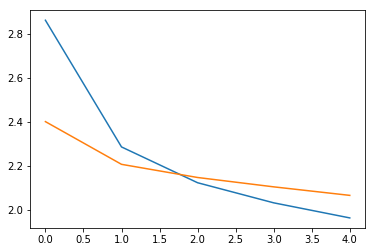

In [24]:
plt.plot(train_losses)
plt.plot(valid_losses)

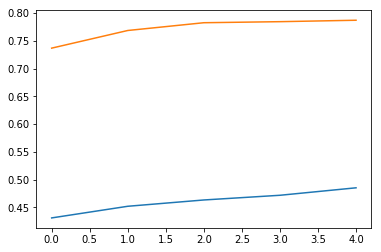

In [25]:
plt.plot(accs)
plt.plot(acc_ks)

### Evaluations

With 486 target classes, it is almost impossible to diagnose how well your model performs by looking at confusion matrix like you would normally do. Here we provide the idea of an "accuracy curve" as possible model evaluation tool.

**Conceptual Assignment** Looking at the plot below, what is the optimal number of snaps we should recommend to users?

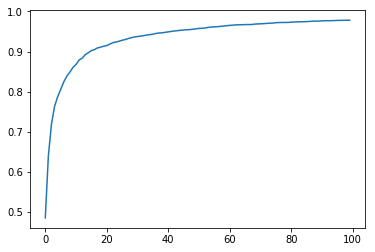

In [26]:
#accurayc curve
acc_curve_sta = []
for i in range(1,101):
    acc_curve_sta.append(score_topk_probs(probs,y,k=i))
plt.plot(acc_curve_sta)

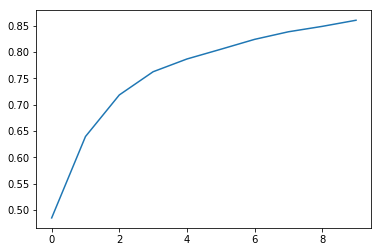

In [27]:
_ = plt.plot(acc_curve_sta[:10])

## Embedding Visualization

We can use the embeddings learned as a representation of each index. For instance, we can perform clustering of users based on the user embeddings. This can be thought as grouping users together according to their snap usage behaviors.

In [28]:
model.sta_layers

ModuleList(
  (0): Embedding(501, 52)
  (1): Embedding(501, 52)
  (2): Embedding(501, 52)
  (3): Embedding(501, 52)
  (4): Embedding(5, 4)
  (5): Embedding(581, 57)
  (6): Embedding(231, 34)
)

In [29]:
user_embeddings = model.sta_layers[6].weight.data.numpy()
user_embeddings.shape

(231, 34)

In [30]:
#tnse
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=1, init='pca', n_iter=1000, random_state=1412)
plot_df = pd.DataFrame(tsne.fit_transform(user_embeddings))
plot_df.columns = ['x','y']
plot_df.head()

,x,y
0,-24.368120,17.766628
1,-26.337364,16.477201
2,-18.759256,46.039112
3,7.801177,-35.152336
4,38.408318,-42.840904


In [31]:
from plotnine import *
g = ggplot(plot_user_org, aes(x='x',y='y')) + geom_point() + theme_minimal()
g

NameError: name 'plot_user_org' is not defined

Here we only had 231 users so the plot is not as impressive/useful. Below is a plot of 5,000 users as a result of training a recommendation for 7 million users. Blue dots are converted customers and red dots are potential customers. 

![TSNE](images/tsne.png)